In [ ]:
from pathlib import Path
import pandas as pd
import spacy
from typing import List
import pandas as pd
from pathlib import Path
import sys
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [ ]:
import tensorflow as tf
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/data_folder'

base_folder = Path(base_path)
data_folder = base_folder

Mounted at /content/drive


In [ ]:
df_train_full = pd.read_csv(data_folder/'reddit_200k_train.csv', index_col=0, encoding='latin-1')
df_test_full = pd.read_csv(data_folder/'reddit_200k_test.csv', index_col=0, encoding='latin-1')

In [ ]:
df_train_full = df_train_full.drop(columns=['score.x',	'parent_id.x',	'id'	,'created_utc.x', 'retrieved_on'])
df_test_full = df_test_full.drop(columns=['score.x',	'parent_id.x',	'id'	,'created_utc.x', 'retrieved_on'])

In [ ]:
df_train_full.columns

Index(['body', 'REMOVED'], dtype='object')

In [ ]:
print(df_train_full.isnull().sum(), df_test_full.isnull().sum())

body       0
REMOVED    0
dtype: int64 body       0
REMOVED    0
dtype: int64


In [ ]:
train_df= df_train_full.sample(frac=0.1, replace=True, random_state=1)
test_df = df_test_full.sample(frac=0.1, replace=True, random_state=1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
import re
import spacy
import numpy as np
from nltk.stem.porter import PorterStemmer
import os

class SpacyPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, model, *, batch_size = 64, lemmatize=True, lower=True, remove_stop=True,
                remove_punct=True, remove_email=True, remove_url=True, remove_num=True, stemming = True,
                add_user_mention_prefix=True, remove_hashtag_prefix=True, basic_clean_only=True):

        self.model = model
        self.batch_size = batch_size
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lower = lower
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix
        self.basic_clean_only = basic_clean_only

        if lemmatize and stemming:
            raise ValueError("Only one of 'lemmatize' and 'stemming' can be True.")

        # Validate basic_clean_only option
        if self.basic_clean_only and (lemmatize or lower or remove_stop or remove_punct or remove_num or stemming or
                                      add_user_mention_prefix or remove_hashtag_prefix):
            raise ValueError("If 'basic_clean_only' is set to True, other processing options must be set to False.")

        # Assign lemmatize and stemming

        self.lemmatize = lemmatize
        self.stemming = stemming

    def basic_clean(self, text):
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        text = re.sub(r'[\n\r]', ' ', text)
        return text.strip()

    def get_cores(self):
        """
        Get the number of CPU cores to use in parallel processing.
        """
        # Get the number of CPU cores available on the system.
        num_cores = os.cpu_count()
        if num_cores < 3:
            use_cores = 1
        else:
            use_cores = num_cores // 2 + 1
        return use_cores

    def spacy_preprocessor(self, texts):
        final_result = []
        nlp = spacy.load(self.model)

        # Disable unnecessary pipelines in spaCy model
        if self.lemmatize:
            # Disable parser and named entity recognition
            disabled_pipes = ['parser', 'ner']
        else:
            # Disable tagger, parser, attribute ruler, lemmatizer and named entity recognition
            disabled_pipes = ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

        with nlp.select_pipes(disable=disabled_pipes):
          # Modify tokenizer behavior based on user_mention_prefix and hashtag_prefix settings
          if self.add_user_mention_prefix or self.remove_hashtag_prefix:
              prefixes = list(nlp.Defaults.prefixes)
              if self.add_user_mention_prefix:
                  prefixes += ['@']  # Treat '@' as a separate token
              if self.remove_hashtag_prefix:
                  prefixes.remove(r'#')  # Don't separate '#' from the following text
              prefix_regex = spacy.util.compile_prefix_regex(prefixes)
              nlp.tokenizer.prefix_search = prefix_regex.search

          # Process text data in parallel using spaCy's nlp.pipe()
          for doc in nlp.pipe(texts, batch_size=self.batch_size, n_process=self.get_cores()):
              filtered_tokens = []
              for token in doc:
                  # Check if token should be removed based on specified filters
                  if self.remove_stop and token.is_stop:
                      continue
                  if self.remove_punct and token.is_punct:
                      continue
                  if self.remove_num and token.like_num:
                      continue
                  if self.remove_url and token.like_url:
                      continue
                  if self.remove_email and token.like_email:
                      continue

                  # Append the token's text, lemma, or stemmed form to the filtered_tokens list
                  if self.lemmatize:
                      filtered_tokens.append(token.lemma_)
                  elif self.stemming:
                      filtered_tokens.append(PorterStemmer().stem(token.text))
                  else:
                      filtered_tokens.append(token.text)

              # Join the tokens and apply lowercasing if specified
              text = ' '.join(filtered_tokens)
              if self.lower:
                  text = text.lower()
              final_result.append(text.strip())

        return final_result


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        try:
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f'Expected list or numpy array, got {type(X)}')

            x_clean = [self.basic_clean(text).encode('utf-8', 'ignore').decode() for text in X]

            # Check if only basic cleaning is required
            if self.basic_clean_only:
                return x_clean  # Return the list of basic-cleaned texts

            x_clean_final = self.spacy_preprocessor(x_clean)
            return x_clean_final

        except Exception as error:
            print(f'An exception occurred: {repr(error)}')


# import spacy pre-processor from custom module
preprocessor = SpacyPreprocessor(model='en_core_web_sm', batch_size=500, lemmatize=True, lower=True,
                                    remove_stop=True, remove_punct=True, remove_email=True,
                                    remove_url=True, remove_num=False, stemming=False,
                                    add_user_mention_prefix=False, remove_hashtag_prefix=False, basic_clean_only=False)

In [ ]:
train_df['body_processed'] = preprocessor.fit_transform(train_df['body'].values)

<ipython-input-10-9b2bb79edd15>:41: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
test_df['body_processed'] = preprocessor.fit_transform(test_df['body'].values)

<ipython-input-10-9b2bb79edd15>:41: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
train_df = train_df.drop(columns=['body'])
test_df = test_df.drop(columns=['body'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


#Vectorize the entire dataset
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_df['body_processed']).toarray()
y = train_df['REMOVED'].astype(int)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Transform the test data using the same vectorizer
X_test = vectorizer.transform(test_df['body_processed']).toarray()
y_test = test_df['REMOVED'].astype(int)



# ***Implement Tensorflow.***

In [ ]:
import tensorflow as tf
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       2,560,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,692,097 (10.27 MB)

 Trainable params: 2,692,097 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6251 - loss: 0.6365 - val_accuracy: 0.6947 - val_loss: 0.5696
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7615 - loss: 0.4903 - val_accuracy: 0.6923 - val_loss: 0.5790
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8373 - loss: 0.3631 - val_accuracy: 0.6896 - val_loss: 0.6404
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9108 - loss: 0.2334 - val_accuracy: 0.6840 - val_loss: 0.8253
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9538 - loss: 0.1305 - val_accuracy: 0.6765 - val_loss: 1.0354
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9756 - loss: 0.0687 - val_accuracy: 0.6825 - val_loss: 1.2625
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9789 - loss: 0.0536 - val_accuracy: 0.6870 - val_loss: 1.3209
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9859 - loss: 0.0418 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_val_pred = (model.predict(X_val_tf) > 0.5).astype(int)
print("TensorFlow Validation Results:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
TensorFlow Validation Results:
[[1488  554]
 [ 538  771]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2042
           1       0.58      0.59      0.59      1309

    accuracy                           0.67      3351
   macro avg       0.66      0.66      0.66      3351
weighted avg       0.67      0.67      0.67      3351



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_tf, y_train_tf,

    validation_data=(X_val_tf, y_val_tf),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9901 - loss: 0.0178 - val_accuracy: 0.6753 - val_loss: 2.1025
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9918 - loss: 0.0166 - val_accuracy: 0.6738 - val_loss: 2.0615
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9909 - loss: 0.0173 - val_accuracy: 0.6756 - val_loss: 2.0151
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9911 - loss: 0.0177 - val_accuracy: 0.6699 - val_loss: 1.9886
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9916 - loss: 0.0162 - val_accuracy: 0.6807 - val_loss: 2.2259
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9915 - loss: 0.0172 - val_accuracy: 0.6789 - val_loss: 2.1032
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0167 - val_accuracy: 0.6825 - val_loss: 2.1718
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9909 - loss: 0.0173 - val_accuracy: 0.

In [ ]:
y_test_pred = (model.predict(X_test_tf) > 0.5).astype(int)
print("Test Set Results:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Set Results:
[[2399 1045]
 [ 848 1292]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      3444
           1       0.55      0.60      0.58      2140

    accuracy                           0.66      5584
   macro avg       0.65      0.65      0.65      5584
weighted avg       0.67      0.66      0.66      5584



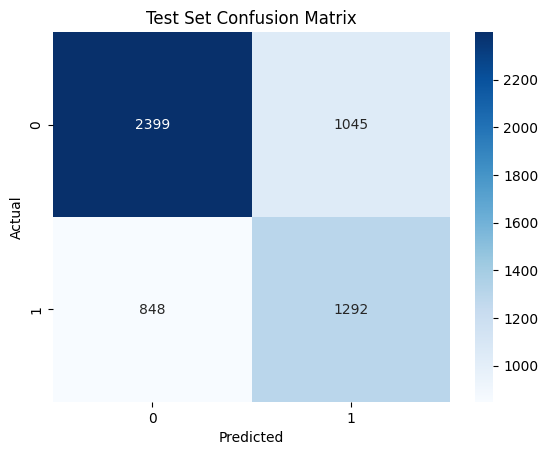

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

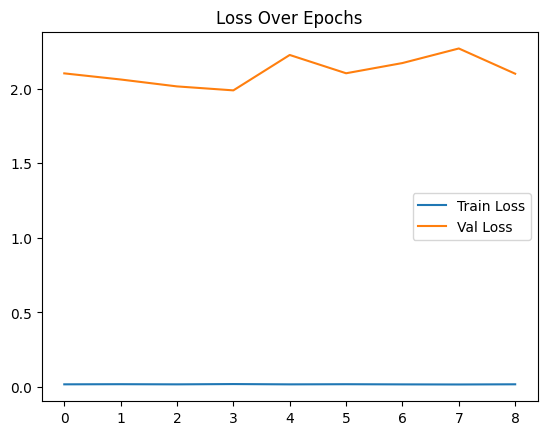

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

def predict_comment(comment, preprocessor, vectorizer, model):

    cleaned = preprocessor.basic_clean(comment)

    processed = preprocessor.transform([cleaned])[0]

    vectorized = vectorizer.transform([processed]).toarray()

    extra_features = np.array([[len(comment), len(processed.split()), comment.count('!')]])

    input_data = np.hstack((vectorized, extra_features))

    input_data = input_data[:, :5000]

    input_tf = tf.convert_to_tensor(input_data, dtype=tf.float32)

    probability = model.predict(input_tf)[0][0]

    prediction = 1 if probability > 0.5 else 0

    return 'Removed' if prediction == 1 else 'Not Removed', probability




preprocessor = SpacyPreprocessor(model='en_core_web_sm', batch_size=500, lemmatize=True, lower=True,
                                 remove_stop=True, remove_punct=True, remove_email=True,
                                 remove_url=True, remove_num=False, stemming=False,
                                 add_user_mention_prefix=False, remove_hashtag_prefix=False,
                                 basic_clean_only=False)

In [ ]:
#Prediction
sample = "Hey everyone, check out my YouTube channel for the BEST weight loss tips! I've lost 50 pounds in a month using this one weird trick. Doctors hate it! #weightloss #fitness #health"
result, prob = predict_comment(sample, preprocessor, vectorizer, model)

print(f"Prediction: {result}, Probability of Removal: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Not Removed, Probability of Removal: 0.49


# **Implement *Logistic* Regression and XGBoost Algorithm**

In [ ]:
from sklearn.linear_model import LogisticRegression
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_val_pred = baseline_model.predict(X_val)
print("Baseline Validation Results:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Baseline Validation Results:
[[1725  317]
 [ 768  541]]
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      2042
           1       0.63      0.41      0.50      1309

    accuracy                           0.68      3351
   macro avg       0.66      0.63      0.63      3351
weighted avg       0.67      0.68      0.66      3351



In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:40:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_val_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Validation Results:")
print(confusion_matrix(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Results:
[[1789  253]
 [ 837  472]]
              precision    recall  f1-score   support

           0       0.68      0.88      0.77      2042
           1       0.65      0.36      0.46      1309

    accuracy                           0.67      3351
   macro avg       0.67      0.62      0.62      3351
weighted avg       0.67      0.67      0.65      3351



In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [3, 5], 'n_estimators': [100, 200]}
grid_search = GridSearchCV(
    xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss'),
    params,
    cv=3,
    scoring='f1'
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'n_estimators': 200}


In [ ]:
y_test_pred = best_model.predict(X_test)
print("Test Set Results:")
print(confusion_matrix(y_test, y_test_pred_LinearXG))
print(classification_report(y_test, y_test_pred_LinearXG))

Test Set Results:
[[2902  542]
 [1317  823]]
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      3444
           1       0.60      0.38      0.47      2140

    accuracy                           0.67      5584
   macro avg       0.65      0.61      0.61      5584
weighted avg       0.66      0.67      0.65      5584



In [ ]:
import numpy as np
def predict_comment_xgb(comment, preprocessor, vectorizer, model):

    cleaned = preprocessor.basic_clean(comment)

    processed = preprocessor.transform([cleaned])[0]

    vectorized = vectorizer.transform([processed]).toarray()

    extra_features = np.array([[len(comment), len(processed.split()), comment.count('!')]])

    input_data = np.hstack((vectorized, extra_features))

    input_data = input_data[:, :5000]

    probability = model.predict_proba(input_data)[:, 1][0]

    prediction = 1 if probability > 0.5 else 0

    return 'Removed' if prediction == 1 else 'Not Removed', probability


In [ ]:
sample = "Hey everyone, check out my YouTube channel for the BEST weight loss tips"
result, prob = predict_comment_xgb(sample, preprocessor, vectorizer, best_model)
print(f"Prediction: {result}, Probability of Removal: {prob:.2f}")

Prediction: Not Removed, Probability of Removal: 0.39


In [ ]:
pip install gradio xgboost scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import joblib

joblib.dump(best_model, "comment_removal_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(preprocessor, "text_preprocessor.pkl")


['text_preprocessor.pkl']

In [ ]:
import gradio as gr
import joblib
import numpy as np

model = joblib.load("comment_removal_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")
preprocessor = joblib.load("text_preprocessor.pkl")

def predict_comment(comment):

    cleaned = preprocessor.basic_clean(comment)
    processed = preprocessor.transform([cleaned])[0]
    vectorized = vectorizer.transform([processed]).toarray()
    extra_features = np.array([[len(comment), len(processed.split()), comment.count('!')]])
    input_data = np.hstack((vectorized, extra_features))
    input_data = input_data[:, :5000]
    probability = model.predict_proba(input_data)[:, 1][0]
    prediction = "Removed" if probability > 0.5 else "Not Removed"
    return f"{prediction} (Probability: {probability * 100:.2f}%)"


iface = gr.Interface(
    fn=predict_comment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a comment..."),
    outputs="text",
    title="Reddit-Comment Removal Prediction",
    description="Enter a comment, and the model will predict the probability of removal."
)


# Launch app
if __name__ == "__main__":
    iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7803dc80d64486f609.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
